# Power spectra estimation example

In this example notebook, we first set up files necessary to run our QML algorithm, then execute it, and finally process the output.

### Necessary imports

Please ensure that all Python requirements have already been installed. If not, this can be done through the usual package managers of `conda` or `pip`.

In [1]:
import time
import numpy as np
from scipy import stats, constants
import healpy as hp
import pymaster as nmt

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.25, rc={'text.usetex': True, 'figure.dpi': 300})

In [2]:
%matplotlib inline

## Set the root filepath to the Git repository

Please set the variable below to where the code was downloaded to

In [3]:
root_filepath = '/home/maraio/Codes/WeakLensingQML_Git'

Now import our custom code

In [4]:
# Add our custom code to the path such that Python can find it
import sys
sys.path.append(f'{root_filepath}/python/lib/PreProcessing/')
sys.path.append(f'{root_filepath}/python/lib/CppInterface/')

# Now import it
from QMLClass import QML
from Y_matrix_class import YMatrix
from GenerateMask import generate_mask, plot_mask
from GeneratePowerSpectra import PowerSpec 
from GenerateCppConstants import generate_constants_h
from CppLib import CppLib

## Generic information about the maps

Here, we specify the HealPix $N_\textrm{side}$ parameter for our maps. As a reminder, the maximum multipole that can be computed from a map with resolution $N_\textrm{side}$ is $3 \times N_\textrm{side} - 1$, with the maximum reliable multipole being $\ell_{\textrm{max}} = 2 N_\textrm{side}$.

Here, we will analyse maps at a resolution of $N_\textrm{side} = 64$ to save computational time.

In [5]:
n_side = 64

# Derived quantities
n_pix = 12 * n_side * n_side

l_max = 2 * n_side
ells = np.arange(2, l_max + 1)
n_ell = len(ells)


l_max_full = 3 * n_side - 1
ells_full = np.arange(2, l_max_full + 1)
n_ell_full = len(ells_full)

## Mask generation

With our basic simulation parameters set, we can now go about generating a simple mask for a space-based Stage-IV like survey, which contains a thick galactic cut (for the Milky Way) and a smaller ecliptic cut (for the Solar System).

In [6]:
# Now generate the galactic and ecliptic cuts for our N_side
mask = generate_mask(3.25, n_side)

The f_sky of the combined galactic & ecliptic map is 35.213 % 


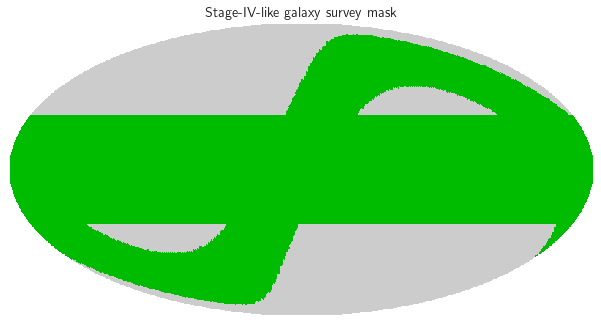

In [7]:
# Now plot this mask
hp.mollview(mask, cmap='nipy_spectral', cbar=False, title='Stage-IV-like galaxy survey mask')

In [8]:
# Now save this mask to our data directory
mask_filepath = f'{root_filepath}/data/masks/SkyMask_N{n_side}_nostars.fits'
hp.write_map(mask_filepath, mask.astype(float), overwrite=True, fits_IDL=False, dtype=np.float64)

## Compute and save the fiducial power spectrum

As the QML estimator requires an estimate for the power spectrum of the maps that wish to be processed, we need to compute and save it to the disk here.

Here, we use the Core Cosmology Library (CCL) to compute this.

We also need to specify the redshift range of sources in our analysis. Here, we take this as a Gaussian distribution centred at $z=1.0$ with a standard deviation of $\sigma_{z} = 0.15$

In [9]:
# First set up some fiducial cosmology values
fiducial_cosmology = {'h': 0.7, 'Omega_c': 0.27, 'Omega_b': 0.045, 'sigma8': 0.75, 'n_s': 0.96,
                      'm_nu': 0.0, 'T_CMB': 2.7255, 'w0': -1.0, 'wa': 0.0}

# Now set up our redshift distribution of galaxies
redshift_range = np.linspace(0.0, 3.0, 500)
redshift_dist = stats.norm.pdf(redshift_range, loc=1.0, scale=0.15)

# Output file path
cl_file_path = f'{root_filepath}/data/theory_cl_vals/TheorySpectra_N{n_side}.dat'

# Set up our PowerSpec class and compute the theory spectra
pow_spec = PowerSpec(n_side, fiducial_cosmology, redshift_range, redshift_dist, cl_file_path)

pow_spec.compute_power_spec()

Evaluating the theory Cl values using CCL
Saved the power spectrum to /home/maraio/Codes/WeakLensingQML_Git/data/theory_cl_vals/TheorySpectra_N64.dat


As the intrinsic ellipticity of galaxies introduces a shot-noise term to the cosmic shear power spectrum, we need to compute it here. We assume that the intrinsic galaxy ellipticity is $\sigma_{\epsilon} = 0.21$, and an observed source galaxy distribution of $\bar{n} = 3 \textrm{ gals / arcmin}^2$

In [10]:
intrinsic_gal_ellip = 0.21
avg_gal_den = 3

# Using the noise parameters, compute the theory noise Cl value
cl_noise = intrinsic_gal_ellip ** 2 / (avg_gal_den / (constants.arcminute ** 2))

# Now compute the noise variance that's expected in each pixel
area_per_pix = 148_510_661 / n_pix

# Then compute the expected number of galaxies per pixel
num_gal_per_pix = avg_gal_den * area_per_pix

# Compute the noise st. dev. and its assocaited variance
noise_std = intrinsic_gal_ellip / np.sqrt(num_gal_per_pix)
noise_var = noise_std ** 2

## Quickly plot the power spectra

Now just plot the saved power spectra 

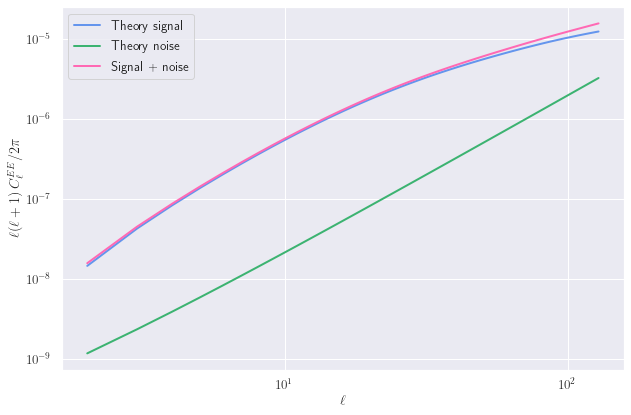

In [11]:
fix, ax = plt.subplots(figsize=(9, 6))

ax.loglog(ells, ells * (ells + 1) * pow_spec.cl_EE[2: l_max + 1] / (2 * np.pi), lw=2, c='cornflowerblue', label='Theory signal')
ax.loglog(ells, ells * (ells + 1) * cl_noise / (2 * np.pi), lw=2, c='mediumseagreen', label='Theory noise')
ax.loglog(ells, ells * (ells + 1) * (pow_spec.cl_EE[2: l_max + 1] + cl_noise) / (2 * np.pi), lw=2, c='hotpink', label='Signal + noise')

ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell (\ell + 1) \, C_{\ell}^{EE} / 2 \pi$')

ax.legend()

plt.tight_layout()
plt.show()

## Generate a mock map corresponding to our power spectrum

We now want to generate a Gaussian map that follows our power spectrum as plotted above. This is the map that we want to estimate the power spectrum of using our QML methods. Here, we specify zero $EB$ and $BB$-modes. 

In [12]:
# Generate a random set of a_{lm} coefficients corresponding to the power spectrum
alm_E, alm_B = hp.synalm([pow_spec.cl_EE, np.zeros_like(pow_spec.cl_EE), np.zeros_like(pow_spec.cl_EE)],
                         lmax=l_max_full, new=True)

# Use these a_{lm} coefficients to generate our spin-2 shear maps
map_gamma1, map_gamma2 = hp.alm2map_spin([alm_E, alm_B], n_side, 2, l_max_full)


# Compute a random noise realisation
noise_gamma1 = np.random.normal(loc=0, scale=noise_std, size=n_pix)
noise_gamma2 = np.random.normal(loc=0, scale=noise_std, size=n_pix)

# Add noise to our signal maps
map_gamma1 += noise_gamma1
map_gamma2 += noise_gamma2

# Now mask our maps
map_gamma1 *= mask
map_gamma2 *= mask


# Overwrite the existing shear maps
map_gamma1_path = f'{root_filepath}/Map_N{n_side}_gamma1.fits'
map_gamma2_path = f'{root_filepath}/Map_N{n_side}_gamma2.fits'

hp.write_map(map_gamma1_path, map_gamma1, overwrite=True, fits_IDL=False, dtype=np.float64)
hp.write_map(map_gamma2_path, map_gamma2, overwrite=True, fits_IDL=False, dtype=np.float64)

We can now plot our cosmic shear maps!

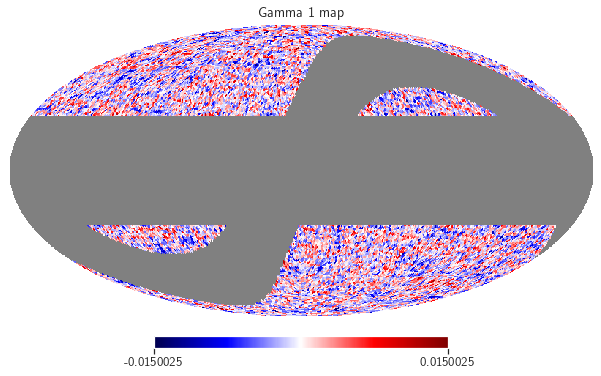

In [13]:
plot_map_gamma1 = map_gamma1.copy()
plot_map_gamma1[plot_map_gamma1 == 0] = np.nan

hp.mollview(plot_map_gamma1, cmap='seismic', cbar=True, title='Gamma 1 map')

## Load in the C++ library

We now need to load in the C++ library which contains the core QML algorithm for both estimating the covariance matrix and using that to estimate the power spectrum of our masked map.

The `num_maps` parameter determines how many maps we should average over when computing the estimate for the Fisher
matrix. The more maps the more accurate the final estimation will be, though with fewer maps the results will be unbiased. Please check our reference paper for a detailed discussion of this topic.

In [14]:
num_maps = 25

In [15]:
# First, generate the "constants.h" file that is necessary for the C++ code to compile (and thus run)
generate_constants_h(n_side, mask, noise_var, num_maps)

Now ensure that the C++ library has been compiled using the constants.h file that's been generated above.
To do so, go to the `cpp` directory and run the following commands
```
mkdir build
cd build/
cmake ..
make all
```

This should have built the shared library producing a `libQMLShearLib.so` file and a `QMLShearExe` executable file.

With the shared library compiled, we can load it into this Python script. First, we need to provide the file path for the shared library.

In [16]:
lib_path = '../cpp/build/libQMLShearLib.so'

Now load in the library

In [17]:
raise RuntimeError('Make sure to do a fresh compile!')

RuntimeError: Make sure to do a fresh compile!

In [18]:
cpp_lib = CppLib(lib_path, mask_filepath, cl_file_path)

## Compute Fisher matrix

With our C++ library loaded, we can now compute and save the estimated Fisher matrix for our QML estimator for our mask and power spectrum

In [19]:
fisher_matrix_out = f'{root_filepath}/data/Fisher_matrix_N{n_side}.dat'

Do note that for map resolutions greater than `N_side` of about 64, the computation of the Fisher matrix can take a seriously long time!

For example, a run at `N_side = 64` using 16 cores took about 45 minutes, so be prepared for some long run-times!

In [20]:
start_time = time.time()

cpp_lib.compute_fisher_matrix(fisher_matrix_out)

print(f'Computation took {(time.time() - start_time):,.1f} seconds')

Computation took 2,278.8 seconds


Once the Fisher matrix has been computed by the C++ code, we can load it in and perform analysis on it

In [21]:
fisher_matrix_QML = np.loadtxt(fisher_matrix_out)

# Delete any modes that corresponds to EB spectra as we can't measure that using our method
fisher_matrix_QML = np.delete(fisher_matrix_QML, np.s_[n_ell_full: 2 * n_ell_full], axis=0)
fisher_matrix_QML = np.delete(fisher_matrix_QML, np.s_[n_ell_full: 2 * n_ell_full], axis=1)

# Explicitly symeterise the Fisher matrix
fisher_matrix_QML = (fisher_matrix_QML.copy() + fisher_matrix_QML.copy().T) / 2

# Invert the Fisher matrix
inv_fisher_QML = np.linalg.inv(fisher_matrix_QML)

# Extract the EE-EE & BB-BB compoenets of the inverse Fisher matrix (the Cl covariance matrix)
cov_EE_EE_QML = inv_fisher_QML[0: n_ell, 0: n_ell]
cov_BB_BB_QML = inv_fisher_QML[n_ell_full: n_ell_full + n_ell, n_ell_full: n_ell_full + n_ell]

## Compute Pseudo-Cl covariance matrix

We now wish to compute the Pseudo-Cl estimate for the covariance matrix to compare to our QML result. Here, we use the `NaMaster` code to compute the PCl values.

In [22]:
# Create a NaMaster field for our given mask
field_mask = nmt.NmtField(mask, None, spin=2)

# Create a bins object with one ell mode per bin
bins = nmt.NmtBin.from_nside_linear(n_side, 1)

# Create a regular workspace object
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(field_mask, field_mask, bins)

# Create a covariance workspace object and then compute the coupling coefficients
covar_wsp = nmt.NmtCovarianceWorkspace()
covar_wsp.compute_coupling_coefficients(field_mask, field_mask, field_mask, field_mask)

# Shortcuts for the power spectrum
cl_EE = pow_spec.cl_EE
cl_EB = np.zeros_like(cl_EE)
cl_BB = np.zeros_like(cl_EE)

# Compute the Gaussian covariance estimation
covar_22_22 = nmt.gaussian_covariance(covar_wsp, 2, 2, 2, 2,
                                [cl_EE + cl_noise, cl_EB, cl_EB, cl_BB + cl_noise],
                                [cl_EE + cl_noise, cl_EB, cl_EB, cl_BB + cl_noise],
                                [cl_EE + cl_noise, cl_EB, cl_EB, cl_BB + cl_noise],
                                [cl_EE + cl_noise, cl_EB, cl_EB, cl_BB + cl_noise],
                                wsp, wb=wsp).reshape([n_ell_full, 4, n_ell_full, 4])

# Extract the specific EE-EE & BB-BB components of the full covariance matrix
cov_EE_EE_PCl = covar_22_22[:, 0, :, 0][0: n_ell, 0: n_ell]
cov_BB_BB_PCl = covar_22_22[:, 3, :, 3][0: n_ell, 0: n_ell]

## Plot the ratio of the PCl to QML covariances

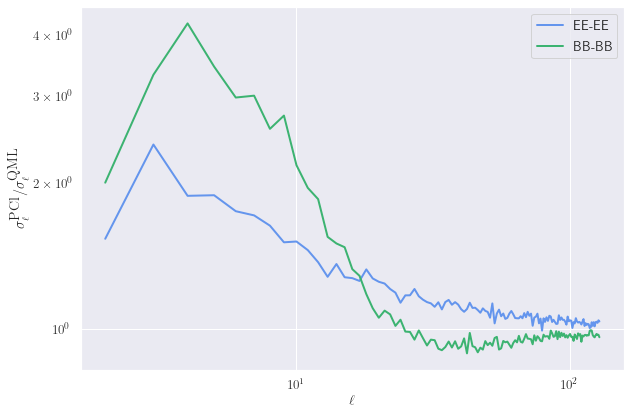

In [23]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.loglog(ells, np.sqrt(np.diag(cov_EE_EE_PCl / cov_EE_EE_QML)), c='cornflowerblue', lw=2, label='EE-EE')
ax.loglog(ells, np.sqrt(np.diag(cov_BB_BB_PCl / cov_BB_BB_QML)), c='mediumseagreen', lw=2, label='BB-BB')

ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\sigma_{\ell}^{\textrm{PCl}} / \sigma_{\ell}^{\textrm{QML}}$')

ax.legend()
plt.tight_layout()
plt.show()

## Now use the Fisher matrix to estimate the power spectrum of cosmic shear maps

With our Fisher matrix estimated, we can now use this to produce an estimate of the power spectrum for the set of cosmic shear maps that was produced above.

In [24]:
# Filepath to store the y_ell values in
y_ell_output = f'{root_filepath}/data/y_ell_out_N{n_side}.dat'

# Execute the C++ code
cpp_lib.compute_power_spectrum(map_gamma1_path, map_gamma2_path, y_ell_output)

With the $y_{\ell}$ values computed, we can read them in and analyse them here

In [25]:
# Load the y_ell values
y_ell_QML = np.loadtxt(y_ell_output)

# Again, we have to delete any modes corresponding to EB spectra as we can't measure them
y_ell_QML = np.delete(y_ell_QML, np.s_[n_ell_full: 2 * n_ell_full], axis=0)

With our $y_{\ell}$ values and the inverse Fisher matrix, we can now compute estimates for the power spectrum coefficients $C_{\ell}$ for the QML estimator.

In [26]:
cl_QML = inv_fisher_QML @ y_ell_QML


# Extract specific components of the Cl values
cl_EE_QML = cl_QML[0: n_ell]
cl_BB_QML = cl_QML[n_ell_full: n_ell_full + n_ell]

Now compute the PCl estimation of the power spectrum using NaMaster

In [27]:
field_shear = nmt.NmtField(mask, [map_gamma1, map_gamma2])
cl_EE_PCl, cl_BB_PCl = nmt.compute_full_master(field_shear, field_shear, bins)[[0, 3], 0: n_ell]

With our estimates of the power spectrum from our two methods, we can plot their results along with the theory curve that the maps were generated from to see how well they match and compare with each other.

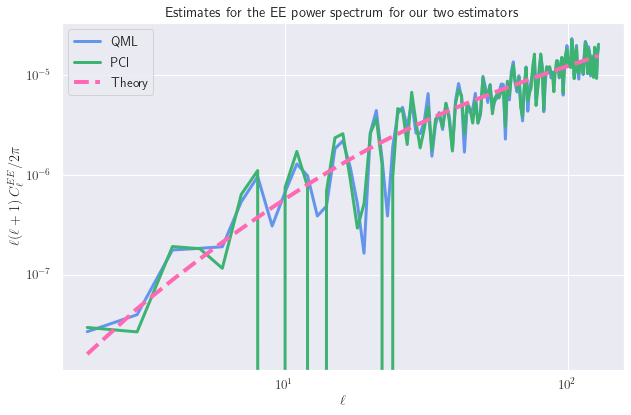

In [28]:
fix, ax = plt.subplots(figsize=(9, 6))

ax.loglog(ells, ells * (ells + 1) * cl_EE_QML / (2 * np.pi), lw=3, c='cornflowerblue', label='QML')
ax.loglog(ells, ells * (ells + 1) * cl_EE_PCl / (2 * np.pi), lw=3, c='mediumseagreen', label='PCl')

ax.loglog(ells, ells * (ells + 1) * (pow_spec.cl_EE[2: l_max + 1] + cl_noise) / (2 * np.pi), lw=4, ls='--', c='hotpink', label='Theory')

ax.set_title('Estimates for the EE power spectrum for our two estimators')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell (\ell + 1) \, C_{\ell}^{EE} / 2 \pi$')

ax.legend()

plt.tight_layout()
plt.show()

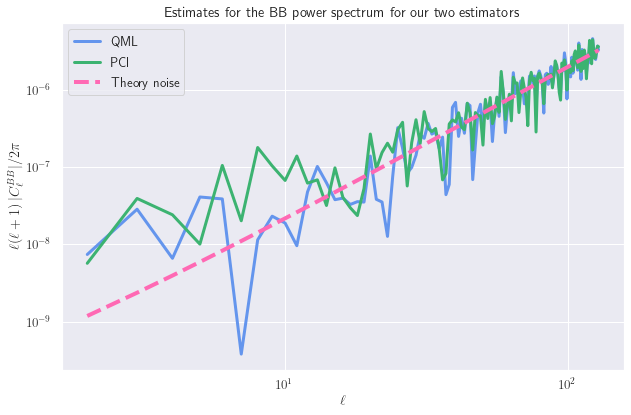

In [29]:
fix, ax = plt.subplots(figsize=(9, 6))

ax.loglog(ells, ells * (ells + 1) * np.abs(cl_BB_QML) / (2 * np.pi), lw=3, c='cornflowerblue', label='QML')
ax.loglog(ells, ells * (ells + 1) * np.abs(cl_BB_PCl) / (2 * np.pi), lw=3, c='mediumseagreen', label='PCl')

ax.loglog(ells, ells * (ells + 1) * cl_noise / (2 * np.pi), lw=4, ls='--', c='hotpink', label='Theory noise')

ax.set_title('Estimates for the BB power spectrum for our two estimators')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell (\ell + 1) \, |C_{\ell}^{BB}| / 2 \pi$')

ax.legend()

plt.tight_layout()
plt.show()

From the two plots above, we can see both estimators broadly predict the true shape of the maps power spectrum which is exactly the desired result! 

## Now compute averages for the QML and PCl estimators

Here, we want to generate an ensemble of maps and run our QML and PCl estimators on them to recover the numerical average power spectrum values and to estimate the numerical covariance matrix for the estimators.

In [37]:
# The number of maps to generate
n_maps = 1_000

In [38]:
cl_EE_QML_vals = []
cl_BB_QML_vals = []

cl_EE_PCl_vals = []
cl_BB_PCl_vals = []


for map_num in range(n_maps):
    if map_num % 50 == 0:
        print(map_num, end=' ', flush=True)
    
    alm_E, alm_B = hp.synalm([pow_spec.cl_EE, np.zeros_like(pow_spec.cl_EE), np.zeros_like(pow_spec.cl_EE)],
                         lmax=l_max_full, new=True)

    # Use these a_{lm} coefficients to generate our spin-2 shear maps
    map_gamma1, map_gamma2 = hp.alm2map_spin([alm_E, alm_B], n_side, 2, l_max_full)


    # Compute a random noise realisation
    noise_gamma1 = np.random.normal(loc=0, scale=noise_std, size=n_pix)
    noise_gamma2 = np.random.normal(loc=0, scale=noise_std, size=n_pix)

    # Add noise to our signal maps
    map_gamma1 += noise_gamma1
    map_gamma2 += noise_gamma2

    # Now mask our maps
    map_gamma1 *= mask
    map_gamma2 *= mask
    
    hp.write_map(map_gamma1_path, map_gamma1, overwrite=True, fits_IDL=False, dtype=np.float64)
    hp.write_map(map_gamma2_path, map_gamma2, overwrite=True, fits_IDL=False, dtype=np.float64)
    
    # Compute the y_ell values using our QML estimator
    cpp_lib.compute_power_spectrum(map_gamma1_path, map_gamma2_path, y_ell_output)
    
    # Load the y_ell values
    y_ell_QML = np.loadtxt(y_ell_output)

    # Again, we have to delete any modes corresponding to EB spectra as we can't measure them
    y_ell_QML = np.delete(y_ell_QML, np.s_[n_ell_full: 2 * n_ell_full], axis=0)
    
    cl_QML = inv_fisher_QML @ y_ell_QML

    # Extract specific components of the Cl values
    cl_EE_QML = cl_QML[0: n_ell]
    cl_BB_QML = cl_QML[n_ell_full: n_ell_full + n_ell]
    
    # Store our QML Cl values into our lists
    cl_EE_QML_vals.append(cl_EE_QML)
    cl_BB_QML_vals.append(cl_BB_QML)
    
    # Now compute the PCl estimates
    field_shear = nmt.NmtField(mask, [map_gamma1, map_gamma2])
    cl_EE_PCl, cl_BB_PCl = nmt.compute_full_master(field_shear, field_shear, bins)[[0, 3], 0: n_ell]
    
    cl_EE_PCl_vals.append(cl_EE_PCl)
    cl_BB_PCl_vals.append(cl_BB_PCl)
    
print('\nDone! :)')

0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 

Now compute averages and covariances for our numerical ensemble

In [39]:
# Averages
cl_EE_QML_avg = np.average(cl_EE_QML_vals, axis=0)
cl_BB_QML_avg = np.average(cl_BB_QML_vals, axis=0)

cl_EE_PCl_avg = np.average(cl_EE_PCl_vals, axis=0)
cl_BB_PCl_avg = np.average(cl_BB_PCl_vals, axis=0)

# Covariances
cl_EE_QML_cov = np.cov(cl_EE_QML_vals, rowvar=False)
cl_BB_QML_cov = np.cov(cl_BB_QML_vals, rowvar=False)

cl_EE_PCl_cov = np.cov(cl_EE_PCl_vals, rowvar=False)
cl_BB_PCl_cov = np.cov(cl_BB_PCl_vals, rowvar=False)

Plot the averages!

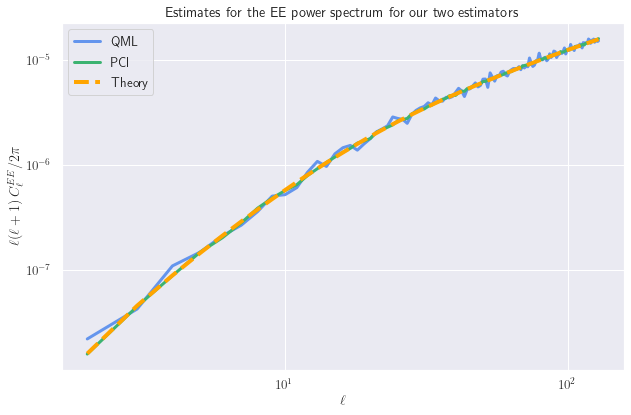

In [40]:
fix, ax = plt.subplots(figsize=(9, 6))

ax.loglog(ells, ells * (ells + 1) * cl_EE_QML_avg / (2 * np.pi), lw=3, c='cornflowerblue', label='QML')
ax.loglog(ells, ells * (ells + 1) * cl_EE_PCl_avg / (2 * np.pi), lw=3, c='mediumseagreen', label='PCl')

ax.loglog(ells, ells * (ells + 1) * (pow_spec.cl_EE[2: l_max + 1] + cl_noise) / (2 * np.pi), lw=4, ls='--', c='orange', label='Theory')

ax.set_title('Estimates for the EE power spectrum for our two estimators')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell (\ell + 1) \, C_{\ell}^{EE} / 2 \pi$')

ax.legend()

plt.tight_layout()
plt.show()

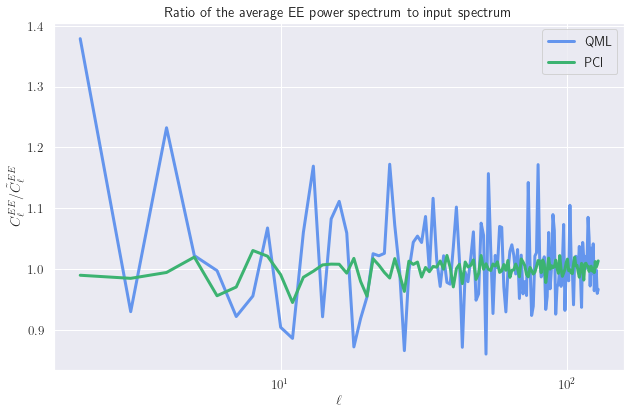

In [41]:
fix, ax = plt.subplots(figsize=(9, 6))

ax.semilogx(ells, cl_EE_QML_avg / (pow_spec.cl_EE[2: l_max + 1] + cl_noise), lw=3, c='cornflowerblue', label='QML')
ax.semilogx(ells, cl_EE_PCl_avg / (pow_spec.cl_EE[2: l_max + 1] + cl_noise), lw=3, c='mediumseagreen', label='PCl')

ax.set_title('Ratio of the average EE power spectrum to input spectrum')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_{\ell}^{EE} / \tilde{C}_{\ell}^{EE}$')

ax.legend()

plt.tight_layout()
plt.show()

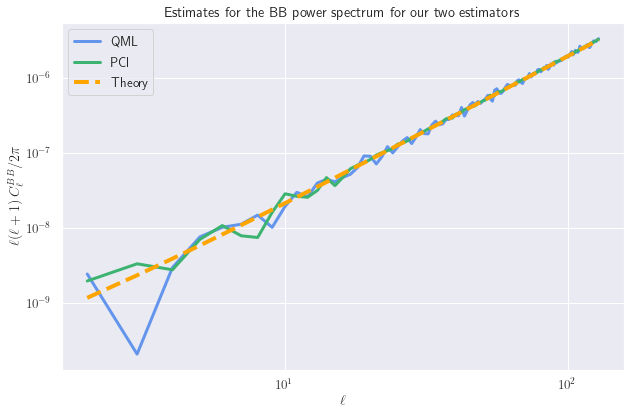

In [42]:
fix, ax = plt.subplots(figsize=(9, 6))

ax.loglog(ells, ells * (ells + 1) * cl_BB_QML_avg / (2 * np.pi), lw=3, c='cornflowerblue', label='QML')
ax.loglog(ells, ells * (ells + 1) * cl_BB_PCl_avg / (2 * np.pi), lw=3, c='mediumseagreen', label='PCl')

ax.loglog(ells, ells * (ells + 1) * (cl_noise) / (2 * np.pi), lw=4, ls='--', c='orange', label='Theory')

ax.set_title('Estimates for the BB power spectrum for our two estimators')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell (\ell + 1) \, C_{\ell}^{BB} / 2 \pi$')

ax.legend()

plt.tight_layout()
plt.show()

Numerical covariances!

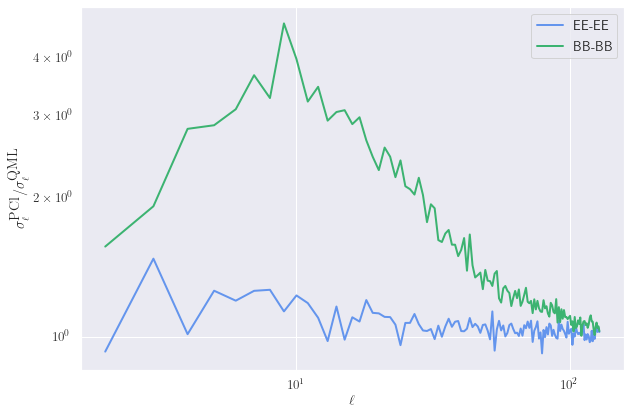

In [43]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.loglog(ells, np.sqrt(np.diag(cl_EE_PCl_cov / cl_EE_QML_cov)), c='cornflowerblue', lw=2, label='EE-EE')
ax.loglog(ells, np.sqrt(np.diag(cl_BB_PCl_cov / cl_BB_QML_cov)), c='mediumseagreen', lw=2, label='BB-BB')

ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\sigma_{\ell}^{\textrm{PCl}} / \sigma_{\ell}^{\textrm{QML}}$')

ax.legend()
plt.tight_layout()
plt.show()